In [186]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.signal import savgol_filter
import pandas as pd
import glob
from scipy.ndimage import gaussian_filter1d
from scipy.signal import fftconvolve


import cv2

In [187]:
def normalize_smooth_signal(ROI_R, ROI_G, ROI_B):
    profiles = []
    for image_1d in [ROI_R, ROI_G, ROI_B]:
        smoothed_profile = gaussian_filter1d(image_1d, sigma=1)
        min_val = np.min(smoothed_profile)
        max_val = np.max(smoothed_profile)
        normalized_profile = (smoothed_profile - min_val) / (max_val - min_val)

        edge_center = np.argmax(np.abs(np.diff(normalized_profile)))

        profiles.append(normalized_profile)
    x = np.arange(0 - edge_center, len(normalized_profile)- edge_center)

    return x, profiles[0], profiles[1], profiles[2]

def compute_area_between_curves(curve1, curve2, curve3):
    """Compute the area between the highest and lowest curves."""
    # Find the highest and lowest curves
    max_curve = np.maximum.reduce([curve1, curve2, curve3])
    min_curve = np.minimum.reduce([curve1, curve2, curve3])

    # Compute the area between max_curve and min_curve
    x = np.arange(len(curve1))
    area = np.trapz(max_curve - min_curve, x)

    return area

def compute_area_between_curves(curve1, curve2, curve3):
    """Compute the area between the highest and lowest curves."""
    # Compute the area between all pairs of curves
    area1 = np.trapz(np.abs(curve1 - curve2)) + np.trapz(np.abs(curve2 - curve1))
    area2 = np.trapz(np.abs(curve1 - curve3)) + np.trapz(np.abs(curve3 - curve1))
    area3 = np.trapz(np.abs(curve2 - curve3)) + np.trapz(np.abs(curve3 - curve2))

    # Find the maximum area among all pairs
    max_area = max(area1, area2, area3)
    if max_area == area1: return "curve12", max_area
    if max_area == area2: return "curve13", max_area
    if max_area == area3: return "curve23", max_area
    #return max_area

def compute_lsf_and_mtf(curve):
    """Compute Line Spread Function (LSF) and Modulation Transfer Function (MTF)."""
    # Compute Line Spread Function (LSF)
    lsf = np.abs(np.diff(curve))
    ##lsf /= np.sum(lsf)  # Normalize LSF to ensure area under curve is 1
    
    # Compute Modulation Transfer Function (MTF)
    mtf = np.abs(np.fft.fftshift(np.fft.fft(lsf)))
    mtf = mtf[:]/np.max(mtf)

    n = len(mtf)
    sampling_rate = 1  # Assuming each sample corresponds to one pixel
    freq = np.fft.fftshift(np.fft.fftfreq(n)) * sampling_rate
    
    return lsf, mtf[len(mtf)//2:], freq[len(mtf)//2:]


In [250]:
file_ROI = 'rect/Basler_acA1300-200uc__23312178__20240508_173907596_0000.tiff'

In [255]:
### show image

def visualize_image(filepath):
    image = plt.imread(filepath)
    ROI_coords = [599, 285, 48, 49]
    plt.imshow(image)
    plt.gca().add_patch(patches.Rectangle((ROI_coords[0],ROI_coords[1]),ROI_coords[2],ROI_coords[3],linewidth=1,edgecolor='white',facecolor='none'))
    plt.yticks([])
    plt.xticks([])
    plt.title("Image of Interest with ROI")

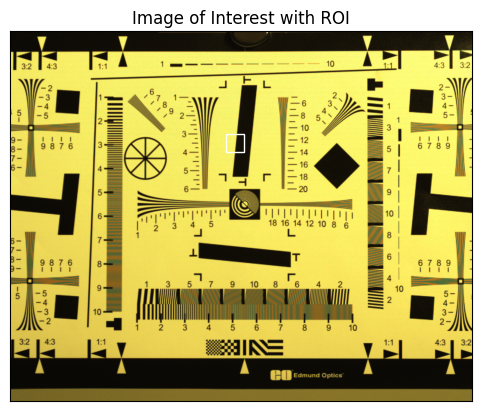

In [256]:
visualize_image(file_ROI)

In [257]:
image = plt.imread(file_ROI)
ROI_coords = [599, 285, 48, 49]
ROI = image[int(ROI_coords[1]):int(ROI_coords[1] + ROI_coords[3]), int(ROI_coords[0]):int(ROI_coords[0] + ROI_coords[2])]

In [258]:
ROI_R = ROI[:,:,0]
ROI_G = ROI[:,:,1]
ROI_B = ROI[:,:,2]

ROI_SFR_R = ROI_R[len(ROI_R)//2]
ROI_SFR_G = ROI_G[len(ROI_G)//2]
ROI_SFR_B = ROI_B[len(ROI_B)//2]

##### Visualize Normalized Edge Profile and CA of a Fixed ROI

Area between highest and lowest curves: 1.871871997326317


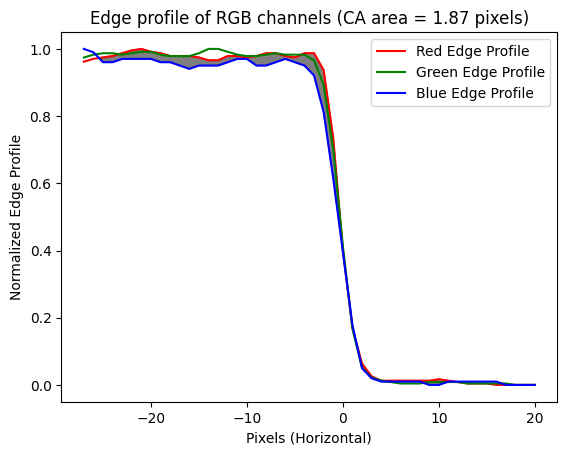

In [259]:
x, r_norm, g_norm, b_norm = normalize_smooth_signal(ROI_SFR_R, ROI_SFR_G, ROI_SFR_B)
curve1, curve2, curve3 = r_norm, g_norm, b_norm
which, area = compute_area_between_curves(curve1, curve2, curve3)
print(f"Area between highest and lowest curves: {area}")
plt.plot(x, curve1, color = 'red', label='Red Edge Profile')
plt.plot(x, curve2, color = 'green', label='Green Edge Profile')
plt.plot(x, curve3, color = 'blue', label='Blue Edge Profile')
if which == "curve12":  plt.fill_between(x, curve1, curve2, where=(curve1 > curve2), interpolate=True, alpha=0.5, color='black')
if which == "curve13":  plt.fill_between(x, curve1, curve3, where=(curve1 > curve3), interpolate=True, alpha=0.5, color='black')
if which == "curve23":  plt.fill_between(x, curve2, curve3, where=(curve2 > curve3), interpolate=True, alpha=0.5, color='black')
plt.xlabel('Pixels (Horizontal)')
plt.ylabel('Normalized Edge Profile')
plt.title(f"Edge profile of RGB channels (CA area = {np.round(area,2)} pixels)")
plt.legend()
plt.show()

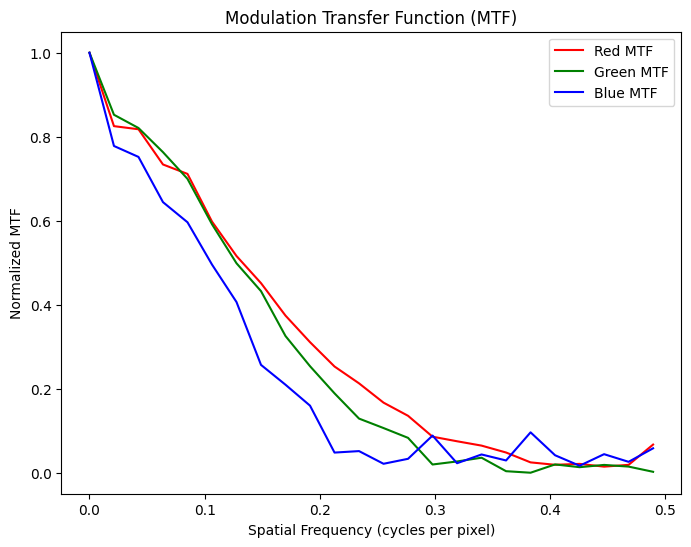

In [260]:

# Example RGB intensity profiles (replace with your actual data)
# Assuming 1D arrays for simplicity
red_curve = r_norm
green_curve = g_norm
blue_curve = b_norm

# Compute LSF and MTF for each channel
red_lsf, red_mtf, freq = compute_lsf_and_mtf(red_curve)
green_lsf, green_mtf, freq = compute_lsf_and_mtf(green_curve)
blue_lsf, blue_mtf, freq = compute_lsf_and_mtf(blue_curve)

# Calculate spatial frequencies corresponding to MTF


# Plotting MTF
plt.figure(figsize=(8, 6))
plt.plot(freq, red_mtf, color='r', label='Red MTF')
plt.plot(freq, green_mtf, color='g', label='Green MTF')
plt.plot(freq, blue_mtf, color='b', label='Blue MTF')
plt.title('Modulation Transfer Function (MTF)')
plt.xlabel('Spatial Frequency (cycles per pixel)')
plt.ylabel('Normalized MTF')
plt.legend()
plt.show()



### Chromatic Abberation of entire ROI

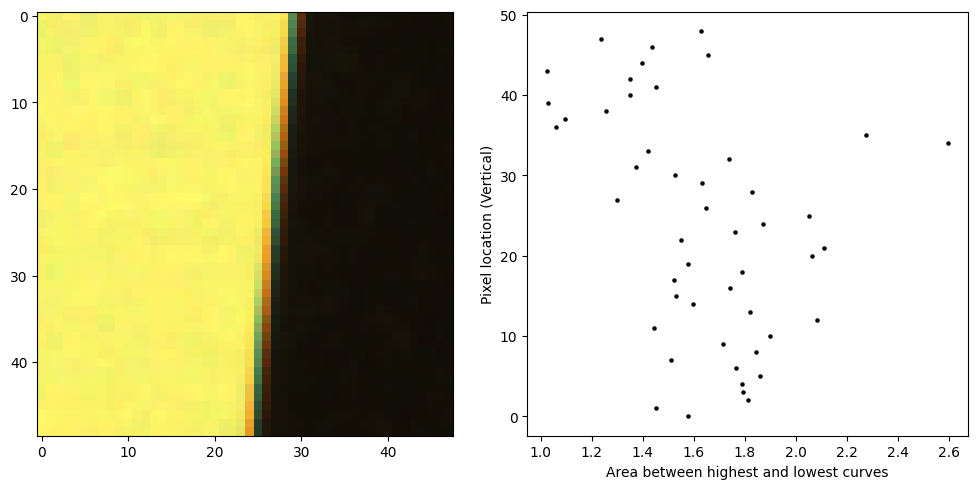

In [261]:
area_v = []

for i in range(len(ROI_R)):
    ROI_SFR_R = ROI_R[i]
    ROI_SFR_G = ROI_G[i]
    ROI_SFR_B = ROI_B[i]

    x, r_norm, g_norm, b_norm = normalize_smooth_signal(ROI_SFR_R, ROI_SFR_G, ROI_SFR_B)
    which, area = compute_area_between_curves(r_norm, g_norm, b_norm)
    area_v.append(area)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(ROI)
ax2.scatter(area_v, np.arange(0,len(ROI_R)), s = 5, color = 'black')

# Set same height for both subplots
#ax1.set_aspect('auto')
ax2.set_aspect('auto')
ax2.set_ylabel('Pixel location (Vertical)')
ax2.set_xlabel('Area between highest and lowest curves')
plt.tight_layout()
plt.show()


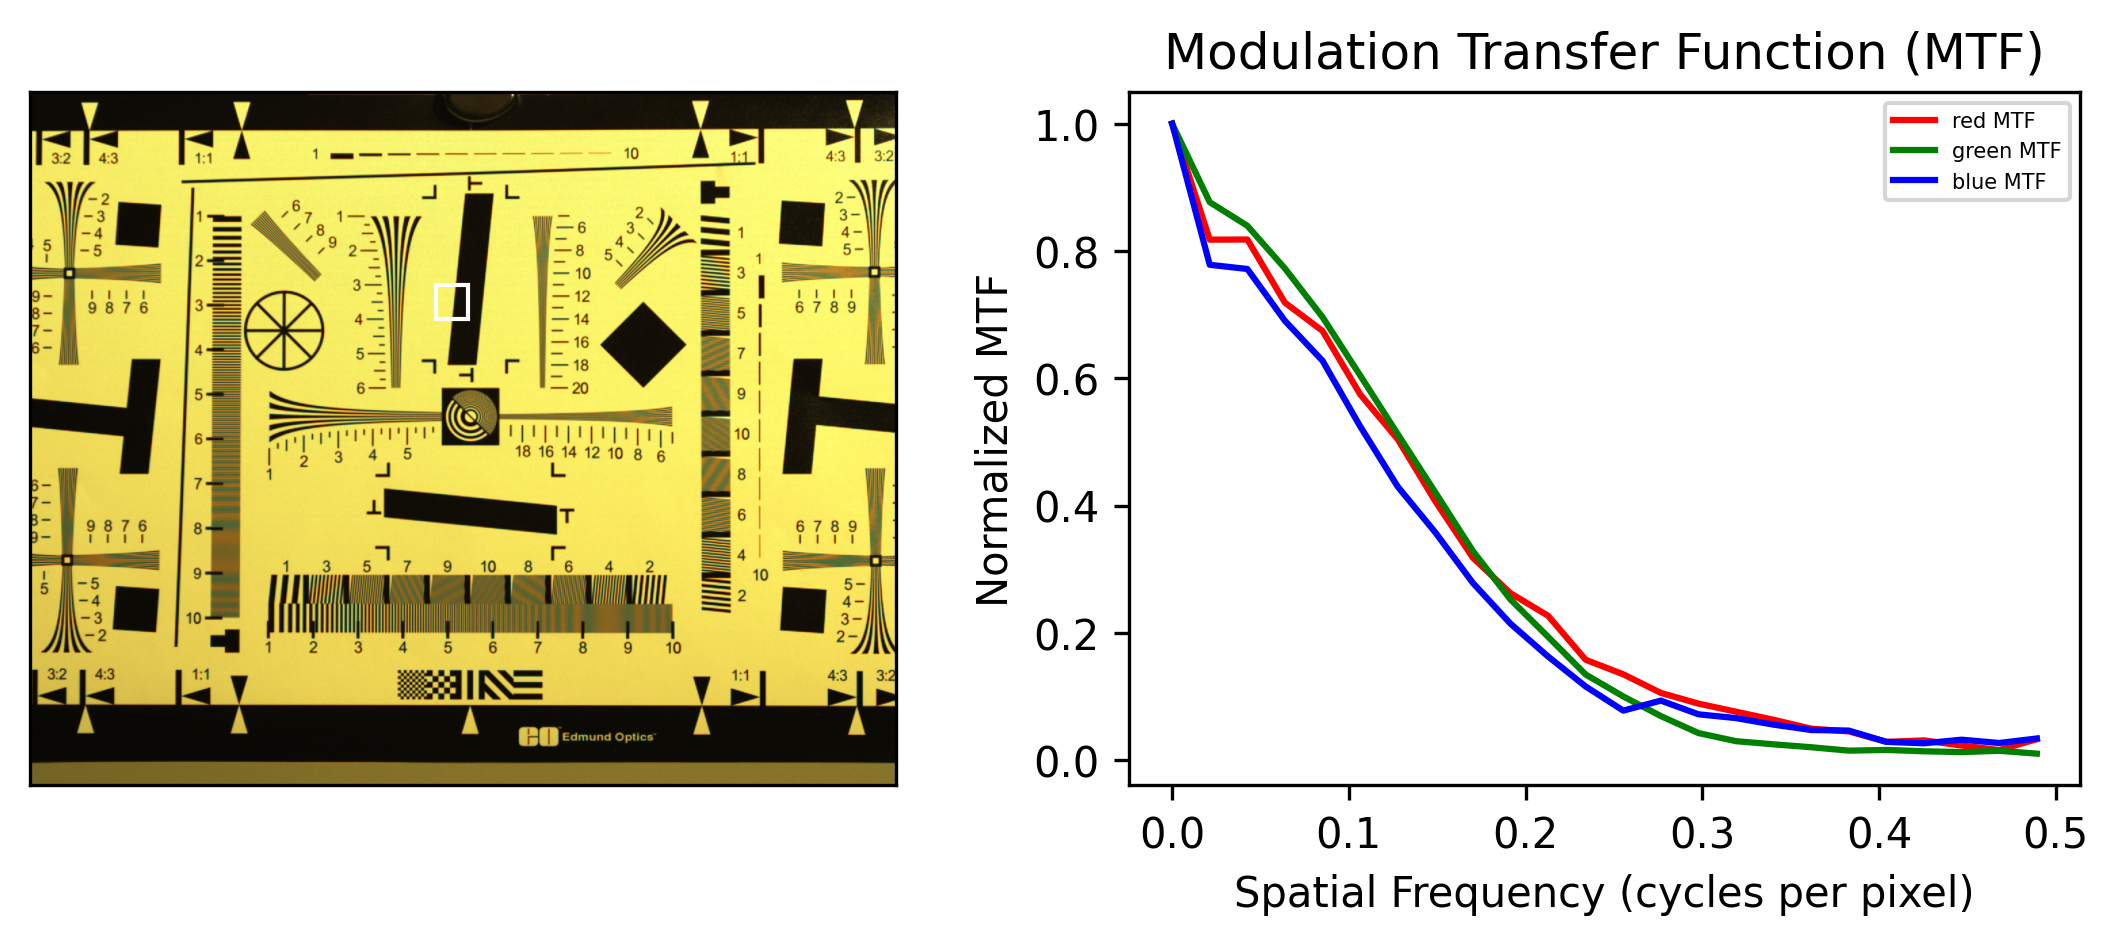

In [262]:
mtf_vals = []

for i in range(len(ROI_R)):
    ROI_SFR_R = ROI_R[i]
    ROI_SFR_G = ROI_G[i]
    ROI_SFR_B = ROI_B[i]

    x, r_norm, g_norm, b_norm = normalize_smooth_signal(ROI_SFR_R, ROI_SFR_G, ROI_SFR_B)
    red_lsf, red_mtf, freq = compute_lsf_and_mtf(r_norm)
    green_lsf, green_mtf, freq = compute_lsf_and_mtf(g_norm)
    blue_lsf, blue_mtf, freq = compute_lsf_and_mtf(b_norm)

    mtf_vals.append([red_mtf, green_mtf, blue_mtf, freq])
mtf_vals = np.array(mtf_vals)

mtf_r_median = np.percentile(mtf_vals[:,0], 50, axis=0)
mtf_g_median = np.percentile(mtf_vals[:,1], 50, axis=0)
mtf_b_median = np.percentile(mtf_vals[:,2], 50, axis=0)
freq = mtf_vals[:,3].mean(axis = 0)


plt.figure(figsize = (6*1.5, 3), dpi = 300, facecolor = None)
plt.subplot(121)
plt.imshow(image)
plt.gca().add_patch(patches.Rectangle((ROI_coords[0],ROI_coords[1]),ROI_coords[2],ROI_coords[3],linewidth=1,edgecolor='white',facecolor='none'))
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.plot(freq, mtf_r_median, color = 'red', linestyle = 'solid', label = 'red MTF')
plt.plot(freq, mtf_g_median, color = 'green', linestyle = 'solid', label = 'green MTF')
plt.plot(freq, mtf_b_median, color = 'blue', linestyle = 'solid', label = 'blue MTF')
plt.title('Modulation Transfer Function (MTF)')
plt.xlabel('Spatial Frequency (cycles per pixel)')
plt.ylabel('Normalized MTF')
plt.legend(fontsize = 5)
plt.show()


### Finding MTF of a user-selected ROI as well as chromatic aberration area

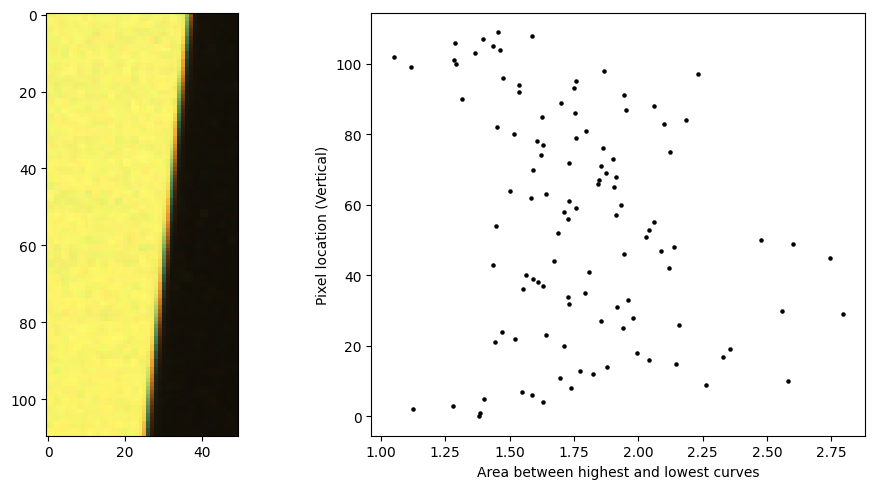

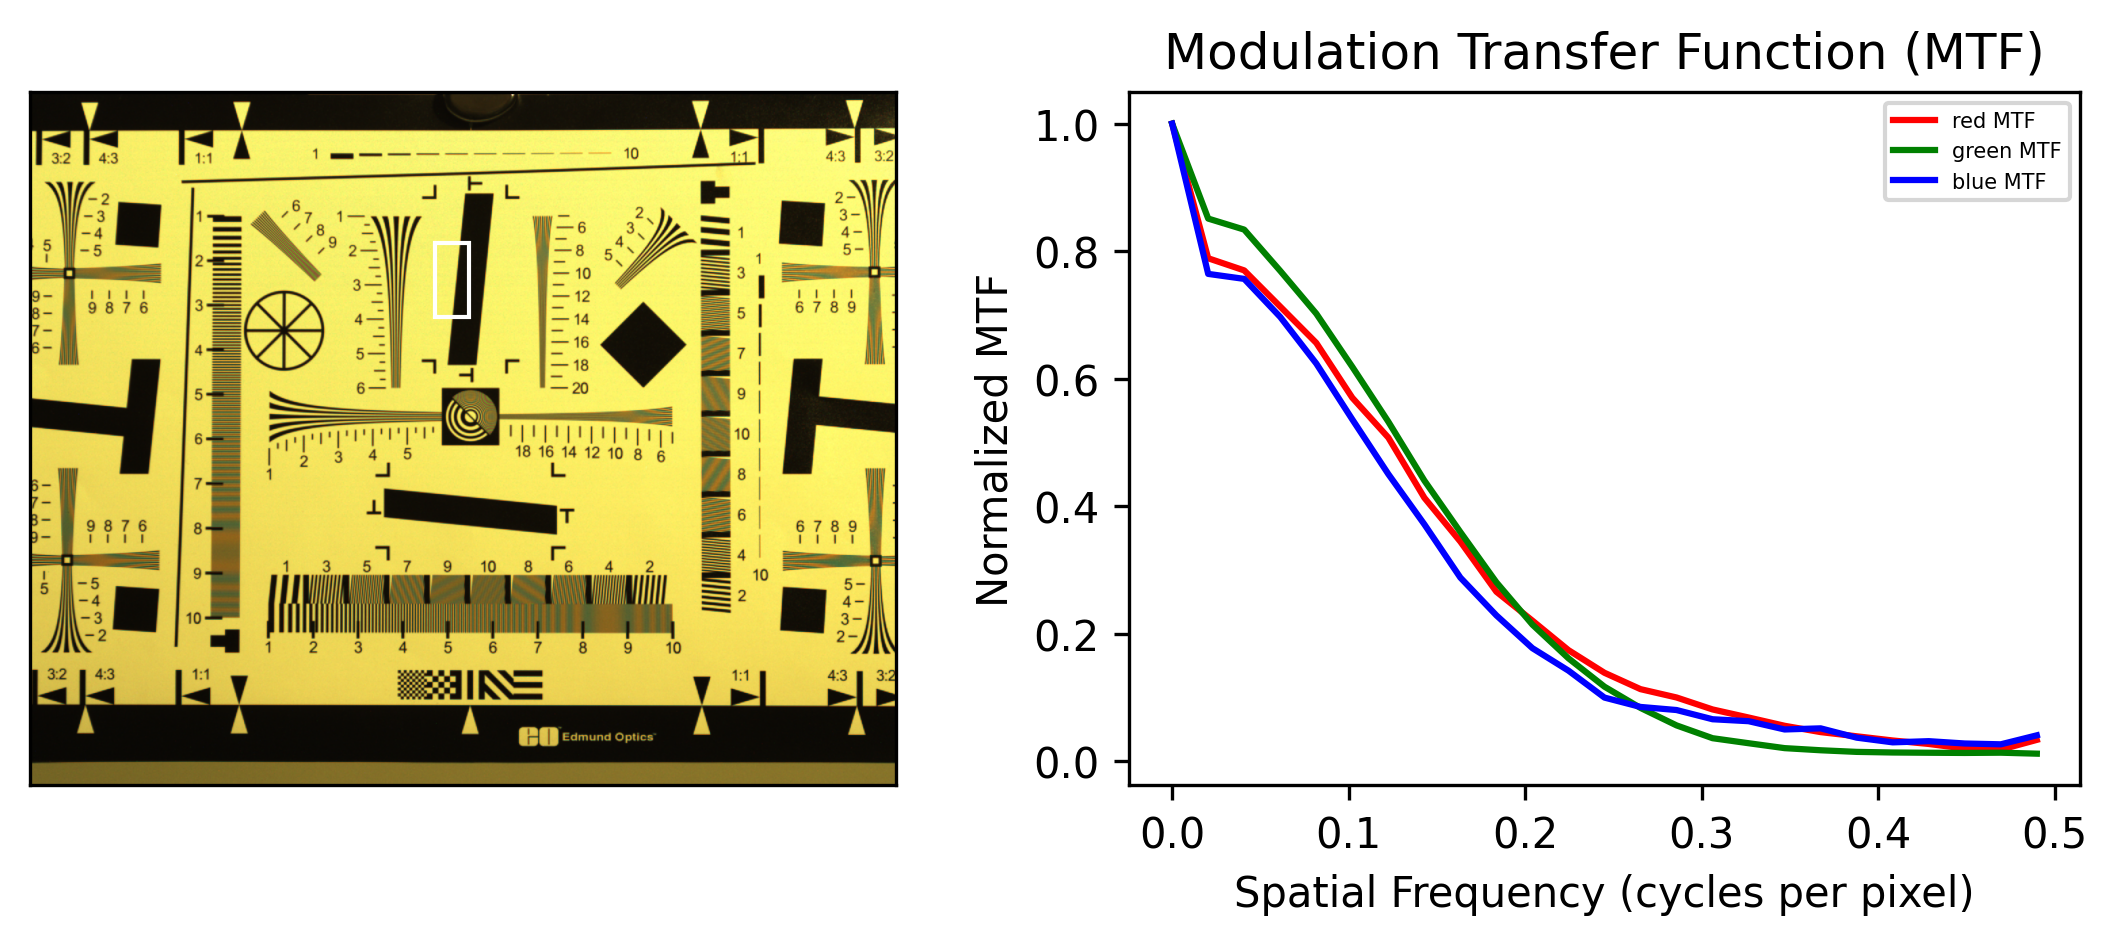

: 

In [263]:
ROI_coords = cv2.selectROI(image)
ROI = image[int(ROI_coords[1]):int(ROI_coords[1] + ROI_coords[3]), int(ROI_coords[0]):int(ROI_coords[0] + ROI_coords[2])]

ROI_R = ROI[:,:,0]
ROI_G = ROI[:,:,1]
ROI_B = ROI[:,:,2]

area_v = []

for i in range(len(ROI_R)):
    ROI_SFR_R = ROI_R[i]
    ROI_SFR_G = ROI_G[i]
    ROI_SFR_B = ROI_B[i]

    x, r_norm, g_norm, b_norm = normalize_smooth_signal(ROI_SFR_R, ROI_SFR_G, ROI_SFR_B)
    which, area = compute_area_between_curves(r_norm, g_norm, b_norm)
    area_v.append(area)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(ROI)
ax2.scatter(area_v, np.arange(0,len(ROI_R)), s = 5, color = 'black')

# Set same height for both subplots
#ax1.set_aspect('auto')
ax2.set_aspect('auto')
ax2.set_ylabel('Pixel location (Vertical)')
ax2.set_xlabel('Area between highest and lowest curves')
plt.tight_layout()
plt.show()


mtf_vals = []
for i in range(len(ROI_R)):
    ROI_SFR_R = ROI_R[i]
    ROI_SFR_G = ROI_G[i]
    ROI_SFR_B = ROI_B[i]

    x, r_norm, g_norm, b_norm = normalize_smooth_signal(ROI_SFR_R, ROI_SFR_G, ROI_SFR_B)
    red_lsf, red_mtf, freq = compute_lsf_and_mtf(r_norm)
    green_lsf, green_mtf, freq = compute_lsf_and_mtf(g_norm)
    blue_lsf, blue_mtf, freq = compute_lsf_and_mtf(b_norm)

    mtf_vals.append([red_mtf, green_mtf, blue_mtf, freq])
mtf_vals = np.array(mtf_vals)

mtf_r_median = np.percentile(mtf_vals[:,0], 50, axis=0)
mtf_g_median = np.percentile(mtf_vals[:,1], 50, axis=0)
mtf_b_median = np.percentile(mtf_vals[:,2], 50, axis=0)
freq = mtf_vals[:,3].mean(axis = 0)


plt.figure(figsize = (6*1.5, 3), dpi = 300, facecolor = None)
plt.subplot(121)
plt.imshow(image)
plt.gca().add_patch(patches.Rectangle((ROI_coords[0],ROI_coords[1]),ROI_coords[2],ROI_coords[3],linewidth=1,edgecolor='white',facecolor='none'))
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.plot(freq, mtf_r_median, color = 'red', linestyle = 'solid', label = 'red MTF')
plt.plot(freq, mtf_g_median, color = 'green', linestyle = 'solid', label = 'green MTF')
plt.plot(freq, mtf_b_median, color = 'blue', linestyle = 'solid', label = 'blue MTF')
plt.title('Modulation Transfer Function (MTF)')
plt.xlabel('Spatial Frequency (cycles per pixel)')
plt.ylabel('Normalized MTF')
plt.legend(fontsize = 5)
plt.show()
